# 3D Finite Element Analysis with SolidSPy

In this notebook, we:
- Generate a **3D mesh** for a rectangular domain using a custom `structure_3d.py` script.
- **Assemble** the global stiffness matrix using SolidSPy's subroutines.
- **Apply** point loads at the top face of the 3D block.
- **Solve** for the displacements using a static solver.
- **Post-process** and **plot** the resulting stress fields, boundary conditions, and load arrows.

Make sure to have:
- `structure_3d.py` in the **same directory** as this notebook.
- **`solidsypy`** installed (`pip install solidsypy`).


## 1. Imports

We import **NumPy** and the necessary modules from **SolidSPy** (`assemutil`, `postprocesor`, `uelutil`, and `solutil`).
We also import our custom function `structure_3d` for mesh generation.

In [2]:
import numpy as np
import solidspy.assemutil as ass
import solidspy.postprocesor as pos
import solidspy.uelutil as uel
import solidspy.solutil as sol
from generate_3d import structure_3d

## 2. Geometry and Material Setup

Here we define the **dimensions** of our 3D domain:
- `L = 10` (x-length)
- `H = 10` (y-length)
- `W = 30` (z-length)

We also specify:
- `E` (Young's modulus)
- `v` (Poisson's ratio)
- `(nx, ny, nz)` as the number of elements in each direction.

In [3]:
# Geometry parameters
L = 10.0  # X dimension
H = 10.0  # Y dimension
W = 30.0  # Z dimension

# Material properties
E = 206.8e9  # Young's modulus (Pa)
v = 0.28     # Poisson's ratio

# Mesh resolution
nx = 10  # subdivisions in X
ny = 10  # subdivisions in Y
nz = 10  # subdivisions in Z

## 3. Load Definitions

We'll define **point loads** applied at the top face (`z = 30`). In this example:
- All loads are in the **Y direction** (just as an illustrative choice).
- We specify different **positions** on the top face to apply these loads.

Later, we call `structure_3d(...)` with these load directions and positions.

In [4]:
# Define load directions (always in Y, for example)
load_directions_3d = np.array([
    [0, 1, 0],  # Load #1 in Y
    [0, 1, 0],  # Load #2 in Y
    [0, 1, 0]   # Load #3 in Y
])

# Define load positions (z = 30 top face)
load_positions_3d = np.array([
    [5, 5, 30],  # near center
    [5, 1, 30],  # near corner
    [5, 8, 30]   # another corner
])

## 4. Mesh Generation via `structure_3d`

We now generate:
- `nodes`: global coordinates of each node.
- `mats`: material data per element.
- `els`: connectivity of each element.
- `loads`: array of point loads.
- `idx_BC`: index of boundary conditions.

Here, we pass our geometry, material, and load definitions to the `structure_3d` function.

In [5]:
nodes, mats, els, loads, idx_BC = structure_3d(
    L=L,
    H=H,
    W=W,
    E=E,
    v=v,
    nx=nx,
    ny=ny,
    nz=nz,
    dirs=load_directions_3d,
    positions=load_positions_3d
)
print("Mesh generation complete.")
print(f"Number of nodes: {nodes.shape[0]}")
print(f"Number of elements: {els.shape[0]}")

Mesh generation complete.
Number of nodes: 1331
Number of elements: 1000


## 5. System Assembly

We assemble the global stiffness matrix and the global force vector.
- `dim_problem = 3` for 3D.
- `nnodes = 8` for Hexa8 elements.
- We call `ass.node2dof(...)` to generate the DOF mapping.
- Then `ass.assembler(...)` to build the global stiffness matrix.
- Finally, `ass.loadasem(...)` to assemble the right-hand side (load vector).

In [6]:
dim_problem = 3
nnodes = 8
uel_func = uel.elast_hex8  # Element routine for hexa8

# Create DOF mapping
assem_op, IBC, neq = ass.node2dof(
    nodes[:, -dim_problem:], els, ndof_el_max=nnodes * dim_problem
)
print(f"Number of equations (neq): {neq}")

# Assemble global stiffness matrix
stiff_mat, _ = ass.assembler(
    els, mats, nodes[:, :-dim_problem], neq, assem_op, uel=uel_func
)

# Assemble load vector
rhs_vec = ass.loadasem(loads, IBC, neq)
print("System assembly complete.")

Number of equations (neq): 2420
System assembly complete.


## 6. Static System Solution

We solve the linear system \( \mathbf{K} \mathbf{u} = \mathbf{f} \) for the nodal displacements \( \mathbf{u} \).

In [7]:
# Solve for displacements
disp = sol.static_sol(stiff_mat, rhs_vec)
# Map the solution back to all nodes
UCI = pos.complete_disp(IBC, nodes, disp, ndof_node=dim_problem)

print("System solution (displacements) complete.")

System solution (displacements) complete.


## 7. Post-Processing

We compute **strain** and **stress** at each node, using SolidSPy's `strain_nodes_3d`. Then we **normalize** the loads for better visualization of load arrows.

In [8]:
if dim_problem == 3:
    E_nodes, S_nodes = pos.strain_nodes_3d(nodes, els, mats[:, :2], UCI)
else:
    E_nodes, S_nodes = pos.strain_nodes(nodes, els, mats[:, :2], UCI)

# Normalize load vectors for plotting clarity
max_force_component = np.max(np.abs(loads[:, 1:4]))
if max_force_component > 1e-14:
    loads[:, 1:4] /= max_force_component

print("Post-processing: strain, stress, and load normalization complete.")

Post-processing: strain, stress, and load normalization complete.


## 8. Visualization

Finally, we use `fields_plot_3d` to display:
- The **stress** distribution.
- The **boundary conditions** (`show_BC=True`).
- The **load arrows** (`show_loads=True`).

We also enable edges for the mesh, color the arrows in **blue**, and set a larger `arrow_scale`.

/home/kssgarcia/anaconda3/envs/solids-test/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


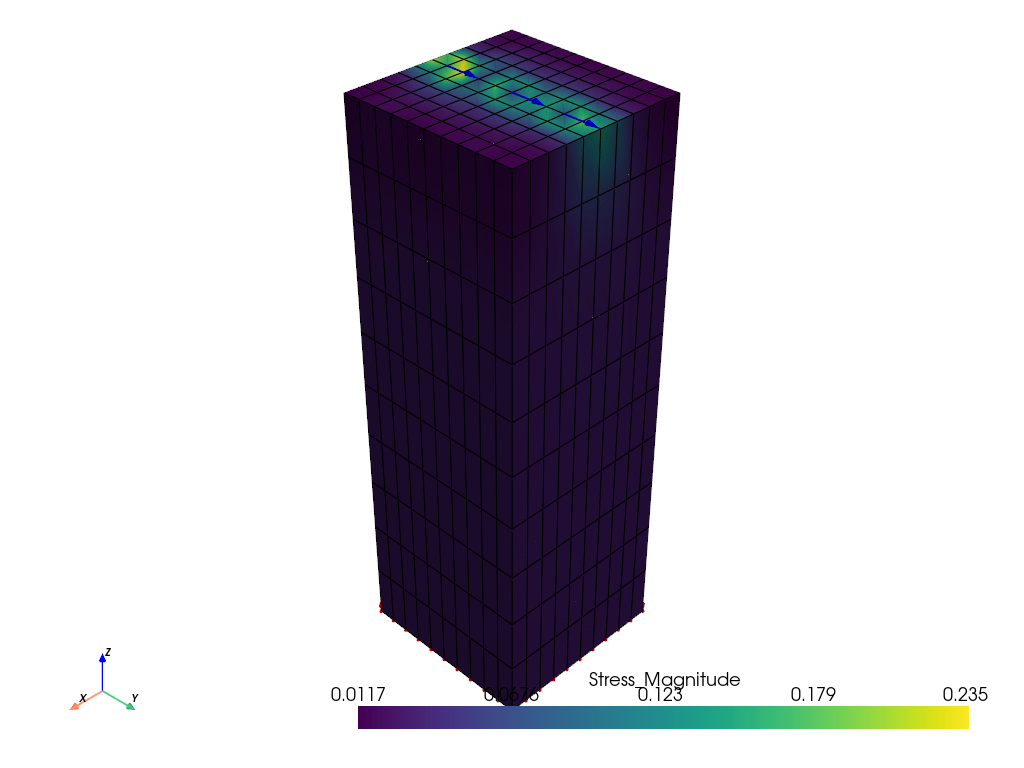


Visualization complete. Look at the plot above.


In [9]:
pos.fields_plot_3d(
    nodes,
    els,
    loads,
    idx_BC,
    S_nodes,
    E_nodes,
    nnodes=8,
    data_type='stress',
    show_BC=True,
    show_loads=True,
    arrow_scale=2.0,
    arrow_color="blue",
    cmap="viridis",
    show_axes=True,
    show_bounds=False,
    show_edges=True
)

print("\nVisualization complete. Look at the plot above.")

## 9. Conclusion

You have successfully:
1. Created a 3D FEM mesh.
2. Assembled and solved the linear system.
3. Visualized the stress field, boundary conditions, and loads.

Feel free to modify any parameters (dimensions, mesh size, loads, material properties) to explore various configurations!